In [1]:
# Packages
import numpy as np
import sklearn 
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.integrate import odeint
import math

from utility_code.utility import utils

#import csvs
train = pd.read_csv("ucla2020-cs145-covid19-prediction/train.csv")
test = pd.read_csv("ucla2020-cs145-covid19-prediction/test.csv")
graph = pd.read_csv("ucla2020-cs145-covid19-prediction/graph.csv")
dummydata = pd.read_csv("data-test/raw_data_test.csv", skiprows=2, thousands=',')

train['Population'] = train['Confirmed'].divide(train['Incident_Rate'])*1e5
train['Active/Population'] = train['Active'].divide(train['Population'])
train['Deaths/Population'] = train['Deaths'].divide(train['Population'])
train['Active/People_Tested*Population'] = train['Active']/train['People_Tested']*train['Population']
train['Recovered/Population'] = train['Recovered']/train['Population']


confirmed = train['Confirmed'].to_list()
daily = [confirmed[i]-confirmed[i-50] for i in range(len(confirmed)) if i-50 >= 0]
for i in range(50):
    daily.insert(0,0)

train['New_Cases'] = daily

tests = train['People_Tested'].to_list()
dailyTests = [tests[i]-tests[i-50] for i in range(len(tests)) if i-50 >= 0]
for i in range(50):
    dailyTests.insert(0,0)

train['New_Tests'] = dailyTests

train['New_Cases/New_Tests'] = train['New_Cases']/train['New_Tests']

statesdata = {}
states = pd.Series.unique(train['Province_State'])
num_states = len(states)
for s in states:
    statesdata[s] = train.loc[train['Province_State'] == s ,:]

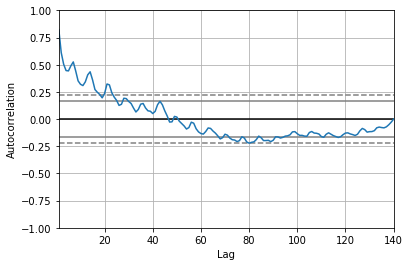

In [2]:
import pandas as pd
confirmed = statesdata['Wisconsin']['Confirmed']
deaths = statesdata['Wisconsin']['Deaths']
deaths = deaths.values + 0.000001
confirmed = confirmed.values
def difference(dataset, interval = 1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i]-dataset[i-interval]
        diff.append(value)
    return np.array(diff)

deaths = difference(np.log(deaths),2)

pd.plotting.autocorrelation_plot(deaths)

In [18]:
p,d,q = 4,2,0
days = 26
mapeTotC = 0
mapeTotD = 0

from statsmodels.tsa.arima_model import ARIMA

def predictARIMA(X, p, d, q, days):
    model = ARIMA(X, order=(p,d,q))
    model_fit = model.fit()
    start = len(X)
    forecast = model_fit.predict(start = start, end = start + days)
    return(forecast)

def difference(dataset, interval = 1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i]-dataset[i-interval]
        diff.append(value)
    return np.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    #yhat = np.exp(yhat)
    return yhat + history[-1]

from statsmodels.tsa.arima.model import ARIMA

proj = {}
for s in states:
    
    a = statesdata[s]
    a = a.reset_index()
    confirmed = a['Confirmed']
    deaths = a['Deaths']
    
    splitpt = len(confirmed) - 15
    confirmed_train, confirmed_test = confirmed[0:splitpt], confirmed[splitpt:]
    deaths_train, deaths_test = deaths[0:splitpt], deaths[splitpt:]
    
    X = confirmed_train.values
    #X = X+0.000001 # pseudocount to avoid log(0)
    #X = np.log(X)
    forecastC = predictARIMA(X, p,d,q, days)
#     modelC = ARIMA(X, order=(5,2,3))
#     model_fitC = modelC.fit()
#     start = len(X)
#     forecastC = model_fitC.predict(start = start, end = start + days)

    Y= deaths_train.values
    Y = Y+0.000001
    Y = np.log(Y)
    forecastD = predictARIMA(Y, p,d,q, days)
#     modelD = ARIMA(Y, order=(5,2,3))
#     model_fitD = modelD.fit()
#     start = len(Y)
#     forecastD = model_fitD.predict(start = start, end = start + days)
    #forecastC = np.exp(forecastC)
    forecastD = np.exp(forecastD)
    df = {'Confirmed': forecastC, 'Deaths': forecastD}
    
    proj[s] = pd.DataFrame(df)
    mapeC = MAPE(pd.DataFrame({'Confirmed':forecastC}), pd.DataFrame(confirmed_test))['Confirmed']
    mapeD = MAPE(pd.DataFrame({'Deaths':forecastD}), pd.DataFrame(deaths_test))['Deaths']
    mapeTotC += mapeC
    mapeTotD += mapeD
    print('For', s, '\n Confirmed MAPE:',mapeC, '\n Deaths MAPE:', mapeD)

For Alabama 
 Confirmed MAPE: 0.0030270551947131166 
 Deaths MAPE: 0.008150988973625291
For Alaska 
 Confirmed MAPE: 0.011643318877752008 
 Deaths MAPE: 0.021254570910052308
For Arizona 
 Confirmed MAPE: 0.003680181573451318 
 Deaths MAPE: 0.008076936376144829
For Arkansas 
 Confirmed MAPE: 0.007056492093289428 
 Deaths MAPE: 0.018965044733100768


/Users/Aditya/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


For California 
 Confirmed MAPE: 0.0029127616955162035 
 Deaths MAPE: 0.002901387434774972
For Colorado 
 Confirmed MAPE: 0.0020289369268450463 
 Deaths MAPE: 0.0011162627822476608


/Users/Aditya/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


For Connecticut 
 Confirmed MAPE: 0.003919795517167863 
 Deaths MAPE: 0.00043154301028110566
For Delaware 
 Confirmed MAPE: 0.011944050215659637 
 Deaths MAPE: 0.0026417150796869122
For Florida 
 Confirmed MAPE: 0.005128945374792907 
 Deaths MAPE: 0.013271948517163764
For Georgia 
 Confirmed MAPE: 0.002806502275411793 
 Deaths MAPE: 0.001204724975243077
For Hawaii 
 Confirmed MAPE: 0.009352745278815904 
 Deaths MAPE: 0.022250245069240563
For Idaho 
 Confirmed MAPE: 0.0033858854838564128 
 Deaths MAPE: 0.004978645828922885


/Users/Aditya/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


For Illinois 
 Confirmed MAPE: 0.002103001766830354 
 Deaths MAPE: 0.0010403113793973485
For Indiana 
 Confirmed MAPE: 0.001489471267589424 
 Deaths MAPE: 0.0008271858646895972


/Users/Aditya/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


For Iowa 
 Confirmed MAPE: 0.005930685173739613 
 Deaths MAPE: 0.011775182043225791
For Kansas 
 Confirmed MAPE: 0.00417957121380145 
 Deaths MAPE: 0.005947567381492305


/Users/Aditya/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


For Kentucky 
 Confirmed MAPE: 0.006587129999959475 
 Deaths MAPE: 0.008939979305468288
For Louisiana 
 Confirmed MAPE: 0.0029763882386032938 
 Deaths MAPE: 0.007974191846450714


/Users/Aditya/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


For Maine 
 Confirmed MAPE: 0.0005142326057610058 
 Deaths MAPE: 0.005083051044174707
For Maryland 
 Confirmed MAPE: 0.00243894377212013 
 Deaths MAPE: 0.0009700150103072721
For Massachusetts 
 Confirmed MAPE: 0.0012616968649128437 
 Deaths MAPE: 0.00077737393367071
For Michigan 
 Confirmed MAPE: 0.000853093626549694 
 Deaths MAPE: 0.0007231934833056967


/Users/Aditya/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


For Minnesota 
 Confirmed MAPE: 0.00170051422787447 
 Deaths MAPE: 0.003225814291123501
For Mississippi 
 Confirmed MAPE: 0.0030792191283918573 
 Deaths MAPE: 0.0023852373288683467
For Missouri 
 Confirmed MAPE: 0.0057986291691697845 
 Deaths MAPE: 0.003764811486413592
For Montana 
 Confirmed MAPE: 0.004436116754445156 
 Deaths MAPE: 0.020166555228885268
For Nebraska 
 Confirmed MAPE: 0.0012314102142583782 
 Deaths MAPE: 0.008880684149484766
For Nevada 
 Confirmed MAPE: 0.007070798367909854 
 Deaths MAPE: 0.004918828268386334
For New Hampshire 
 Confirmed MAPE: 0.0016144391513079812 
 Deaths MAPE: 0.0006040421208377933
For New Jersey 
 Confirmed MAPE: 0.0022936816423018013 
 Deaths MAPE: 0.0002871253256231876


/Users/Aditya/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


For New Mexico 
 Confirmed MAPE: 0.0006677198800562644 
 Deaths MAPE: 0.0017238996807166726
For New York 
 Confirmed MAPE: 8.213991113622153e-05 
 Deaths MAPE: 0.00017444418354983811
For North Carolina 
 Confirmed MAPE: 0.0023198672578986484 
 Deaths MAPE: 0.0059746774497871835
For North Dakota 
 Confirmed MAPE: 0.011798801147585412 
 Deaths MAPE: 0.004781445167910666
For Ohio 
 Confirmed MAPE: 0.00073147886210509 
 Deaths MAPE: 0.002841199749021938
For Oklahoma 
 Confirmed MAPE: 0.0013760510669266366 
 Deaths MAPE: 0.0044011820078495075
For Oregon 
 Confirmed MAPE: 0.006744965319855459 
 Deaths MAPE: 0.007089314021867437
For Pennsylvania 
 Confirmed MAPE: 0.0018084639180334663 
 Deaths MAPE: 0.000663284252927908


LinAlgError: LU decomposition error.

In [5]:
def MAPE(pred, valid):
    pred = pred.reset_index()
    valid = valid.reset_index()
    pred = pred.astype('int64')
    valid = valid.astype('int64')
    v = pred.subtract(valid)
    v = v.divide(valid)
    v = v.abs()
    v = v.sum(axis = 0)
    #print(v)
    #v = v[1]+v[2]
    n = len(pred)
    #print(len(pred))
    return v/(2*n)
#
#MAPE(submission[['Confirmed', 'Deaths']], validation[['Confirmed', 'Deaths']])

In [10]:
print('Without the trend parameter for confirmed:', mapeTotC) #523

Without the trend parameter for confirmed: 0.22241363123139815


In [11]:
print('Without the trend parameter for deaths:', mapeTotD)

Without the trend parameter for deaths: 0.26647074317976094


In [24]:
print('With the params, 4,2,3 for confirmed:', mapeTotC) # good for C!
print('With the 4,2,3 for deaths:', mapeTotD)

With the params, 4,2,3 for confirmed: 0.21210243608979962
With the 4,2,3 for deaths: 0.26341990030777807


In [26]:
print('With the params, 2,2,3 for confirmed:', mapeTotC) # GOOD FOR C!
print('With the 2,2,3 for deaths:', mapeTotD)

With the params, 2,2,3 for confirmed: 0.1893949194911668
With the 2,2,3 for deaths: 0.25949362504775464


In [43]:
#print('With the params, 10,2,3 for confirmed:', mapeTotC)
print('With the 6,2,3 for deaths:', mapeTotD) # GOOD FOR D

With the 6,2,3 for deaths: 0.24447115807485809


In [142]:
print('With the params, 4,2,1 for confirmed:', mapeTotC)
print('With the 4,2,1 for deaths:', mapeTotOh wD) # GOOD FOR D!

With the params, 4,2,1 for confirmed: 0.20066623728045355
With the 4,2,1 for deaths: 0.23821759832698347


In [70]:
print('With the params 4,2,0 for confirmed:', mapeTotC)
print('With the parms above for deaths:', mapeTotD) ## GOOD FOR BOTH!

With the params 4,2,0 for confirmed: 0.14797518105639543
With the parms above for deaths: 0.2358201596243279


In [7]:
print('With the params 1,1,1 for confirmed:', mapeTotC)
print('With the parms above for deaths:', mapeTotD) 

With the params 1,1,1 for confirmed: 0.17404089441983467
With the parms above for deaths: 0.26697120703684923


In [17]:
print('With the params 2,2,2 for confirmed:', mapeTotC)
print('With the parms above for deaths:', mapeTotD) 

With the params 2,2,2 for confirmed: 0.18581905974534663
With the parms above for deaths: 0.2611015188110797


In [20]:
print('With the params 4,2,0 for confirmed:', mapeTotC)
print('With the parms above but also log for deaths:', mapeTotD) # BEST ONE YET! NOT GOOD ON KAGGLE WHY

With the params 4,2,2 for confirmed: 0.14797518105639543
With the parms above but also log for deaths: 0.22118460969592046
